In [7]:
from tvb.simulator.lab import *
from tvb.datatypes.connectivity import Connectivity
import numpy as np
import matplotlib.pyplot as plt
import copy

In [9]:
conn = Connectivity.from_file("connectivity_76.zip")
conn.configure()
N = conn.number_of_regions

2025-05-19 10:13:21,183 - ERROR - tvb.basic.readers - Could not import tvb_data Python module for default data-set!
Traceback (most recent call last):
  File "/opt/anaconda3/envs/tvb_env/lib/python3.10/site-packages/tvb/basic/readers.py", line 222, in try_get_absolute_path
    module_import = importlib.import_module(relative_module)
  File "/opt/anaconda3/envs/tvb_env/lib/python3.10/importlib/__init__.py", line 126, in import_module
    return _bootstrap._gcd_import(name[level:], package, level)
  File "<frozen importlib._bootstrap>", line 1050, in _gcd_import
  File "<frozen importlib._bootstrap>", line 1027, in _find_and_load
  File "<frozen importlib._bootstrap>", line 992, in _find_and_load_unlocked
  File "<frozen importlib._bootstrap>", line 241, in _call_with_frames_removed
  File "<frozen importlib._bootstrap>", line 1050, in _gcd_import
  File "<frozen importlib._bootstrap>", line 1027, in _find_and_load
  File "<frozen importlib._bootstrap>", line 1004, in _find_and_load_unlo

In [11]:
wc = models.WilsonCowan(
    c_ee=np.array([20.0] * N),
    c_ei=np.array([12.0] * N),
    c_ie=np.array([18.0] * N),
    c_ii=np.array([3.0] * N),
    P=np.array([0.45] * N),
    tau_e=np.array([10.0] * N),
    tau_i=np.array([25.0] * N),
)

In [13]:
cpl = coupling.Linear(a=np.array([0.015]))
heun = integrators.HeunDeterministic(dt=0.1)
heun.noise = noise.Additive(nsig=np.array([0.02, 0.02]))

ic = np.zeros((1, 2, N, 1))
ic[0,0,:] = 0.3
ic[0,1,:] = 0.0

In [15]:
def focal_strong_dlpfc_lesion(conn, node_idx=18, weight_scale=0.3, tract_scale=1.5):
    W = conn.weights.copy()
    D = conn.tract_lengths.copy()
    W[node_idx, :] *= weight_scale
    W[:, node_idx] *= weight_scale
    D[node_idx, :] *= tract_scale
    D[:, node_idx] *= tract_scale
    conn_lesion = Connectivity(weights=W, tract_lengths=D,
                               region_labels=conn.region_labels,
                               centres=conn.centres, speed=conn.speed.copy())
    conn_lesion.configure()
    return conn_lesion

In [17]:
def damp_node_dynamics(wc_model, node_idx=18, num_regions=76,
                       P_reduction=0.5, c_ie_increase=1.2):
    """
    Modifies a Wilson-Cowan model object *in place* to damp activity at one node.
    """
    for pname in ('P', 'c_ie'):
        val = getattr(wc_model, pname)
        if val.size == 1:
            setattr(wc_model, pname, np.repeat(val[0], num_regions))
    wc_model.P[node_idx]    *= P_reduction
    wc_model.c_ie[node_idx] *= c_ie_increase

In [19]:
def apply_tdcs_effect(model, node_idx, P_boost_factor=2.0, c_ie_reduction_factor=1/1.2):
    """Simulate anodal tDCS effects by adjusting local excitability in the Wilson-Cowan model."""

    model.P[node_idx] *= P_boost_factor


    model.c_ie[node_idx] *= c_ie_reduction_factor

    print(f"tDCS applied to region {node_idx}:")
    print(f"  New P = {model.P[node_idx]:.4f}")
    print(f"  New c_ie = {model.c_ie[node_idx]:.4f}")

In [21]:
conn_tbi = focal_strong_dlpfc_lesion(conn, node_idx=18)
wc_tbi = copy.deepcopy(wc)

damp_node_dynamics(wc_tbi, node_idx=18, num_regions=N, P_reduction=0.5, c_ie_increase=1.2)
apply_tdcs_effect(wc_tbi, node_idx=18, P_boost_factor=2.0, c_ie_reduction_factor=1/1.2)

tDCS applied to region 18:
  New P = 0.4500
  New c_ie = 18.0000


In [23]:
raw_mon = monitors.Raw()
bold_mon = monitors.Bold(period=2000.0)

In [25]:
sim = simulator.Simulator(
    model=wc_tbi,
    connectivity=conn_tbi,
    coupling=cpl,
    integrator=heun,
    monitors=[raw_mon, bold_mon],
    initial_conditions=ic,
    simulation_length=600000.0  
).configure()

In [27]:
result = sim.run()
(raw_t, raw_dat), (bold_t, bold_dat) = result

2025-05-19 10:17:54,189 - WARNING - tvb.simulator.integrators - random_state supplied for non-stochastic integration


In [29]:
bold_time_sec = bold_t / 1000
bold_signal = bold_dat[:, 0, 18, 0]

In [31]:
discard_time = 7
discard_index = np.where(bold_time_sec >= discard_time)[0][0]
bold_time_trimmed = bold_time_sec[discard_index:]
bold_signal_trimmed = bold_signal[discard_index:]

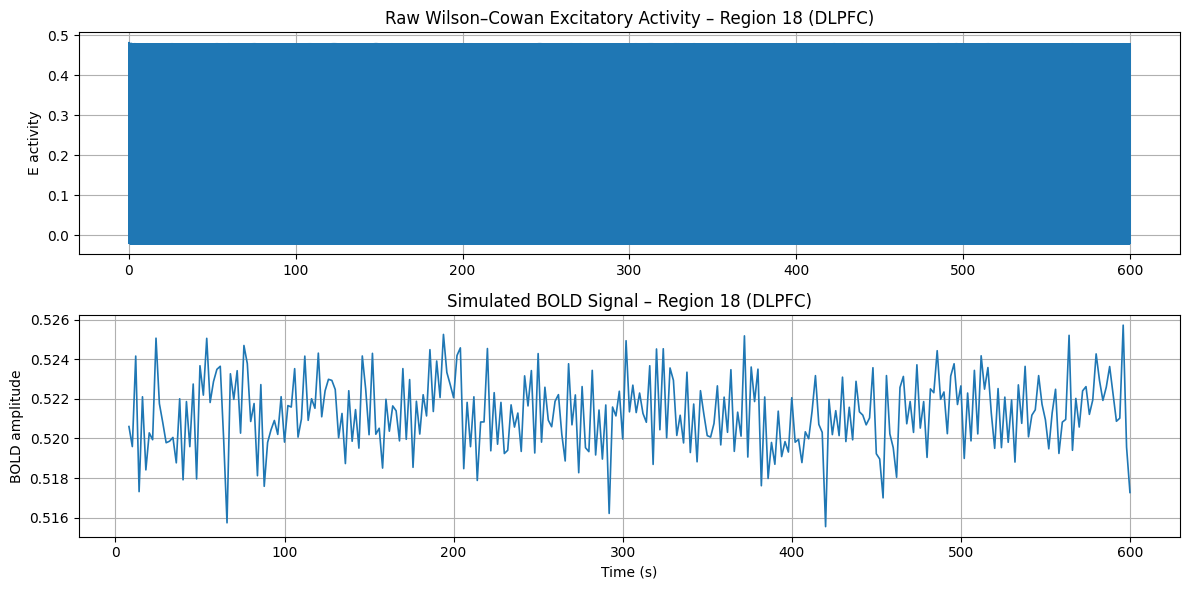

In [43]:
plt.figure(figsize=(12, 6))
plt.subplot(2, 1, 1)
plt.plot(raw_t / 1000, raw_dat[:, 0, 18, 0], lw=1)
plt.title("Raw Wilson–Cowan Excitatory Activity – Region 18 (DLPFC)")
plt.ylabel("E activity"); plt.grid(True)

plt.subplot(2, 1, 2)
plt.plot(bold_time_trimmed, bold_signal_trimmed, lw=1.2)
plt.title("Simulated BOLD Signal – Region 18 (DLPFC)")
plt.xlabel("Time (s)"); plt.ylabel("BOLD amplitude")
plt.grid(True)
plt.tight_layout()
plt.savefig("figures/tbi_strong_tdcs_signals.png", dpi=300, bbox_inches='tight')
plt.show()

In [35]:
time = raw_t
data = raw_dat[:, 0, :, 0]
selected_regions = [18, 23, 51, 74]

In [37]:
start_time = 100000
end_time = 105000
start_idx = (time >= start_time).argmax()
end_idx = (time >= end_time).argmax()

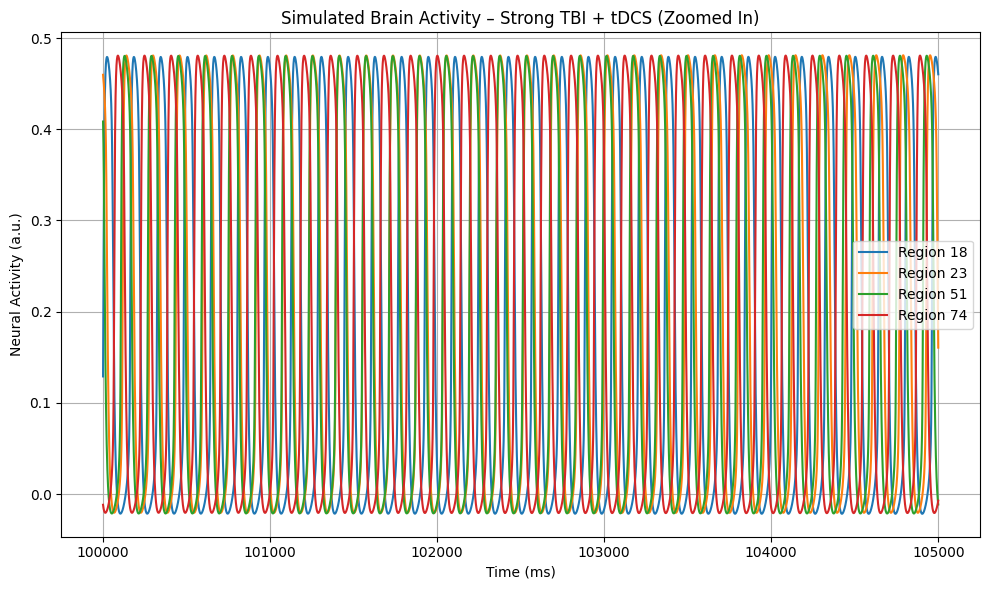

In [45]:
plt.figure(figsize=(10, 6))
for region in selected_regions:
    plt.plot(time[start_idx:end_idx], data[start_idx:end_idx, region], label=f"Region {region}")
plt.title("Simulated Brain Activity – Strong TBI + tDCS (Zoomed In)")
plt.xlabel("Time (ms)")
plt.ylabel("Neural Activity (a.u.)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("figures/tbi_strong_tdcs_zoomed_regions.png", dpi=300, bbox_inches='tight')
plt.show()